# Hi, This is Frank's notebook 

In [50]:
import numpy as np
from matplotlib import pyplot as plt

import datetime

import pandas as pd

## Let's do some data cleaning and ploting

In [21]:
file = '../sunspot_data/NOAA_daily_1945.txt'

data = pd.read_table(file, header=1, delim_whitespace=True)
data

,Year,Month,Day,SSN
0,1945,1,1,10.0
1,1945,1,2,0.0
2,1945,1,3,1.0
3,1945,1,4,2.0
4,1945,1,5,11.0
...,...,...,...,...
26658,2017,12,27,NaN
26659,2017,12,28,NaN
26660,2017,12,29,NaN
26661,2017,12,30,NaN


In [73]:
fmt = '%Y.%m.%d'

times = []

for index, row in data.iloc[:].iterrows():
    s = '%i.%i.%i'%(row['Year'],row['Month'],row['Day'])
    dt = datetime.datetime.strptime(s, fmt)
    times.append(dt)


In [74]:
t = Time(times,)

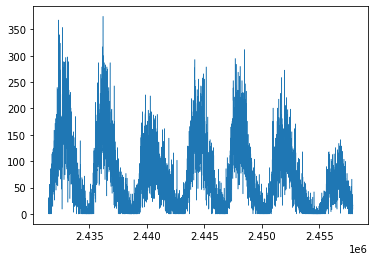

In [77]:
plt.plot(t.jd, data['SSN'], lw=0.5)

In [95]:
stacked = np.vstack((t.jd,data['SSN']))

np.savetxt('NOAA_daily_inJD.txt',stacked.T, fmt='%1.1f',header='Julian_date SSN')